In [1]:
import rtde_control
import rtde_receive
import numpy as np
import sys
import yaml
from matplotlib import pyplot as plt
import cv2

sys.path.append("../../")

from scripts.SurfaceContact.move import move_default_pose
from scripts.USImageCV.models.unet import UNet
from scripts.USImageCV.utils.bunny import bunny_mask_predict, load_bunny_model,max_connected_area
%load_ext autoreload
%autoreload 2

In [2]:
with open('../../config/pose_in_TCP_frame.yaml','r') as f:
    poses = yaml.safe_load(f)

    camera_2_tcp = poses['camera']
    probe_2_tcp = poses['probe']

# Connect to robot

In [3]:
# from recording_upload_server import CaptureServer

rtde_c = rtde_control.RTDEControlInterface("192.168.1.2")
rtde_r = rtde_receive.RTDEReceiveInterface("192.168.1.2")



# Connect to ultrasound image stream

In [4]:
ultrasoud_vid = cv2.VideoCapture('/dev/video2')

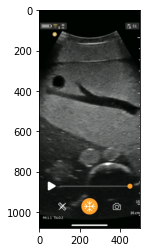

In [6]:

ret, frame = ultrasoud_vid.read()		
plt.imshow(frame)

# Load pre-trained bunny segmentation model

In [5]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = load_bunny_model('../../scripts/USImageCV/model_weights/bunny_seg_model.pth',device)

In [30]:
import time
from collections import deque

def y_direction_search():
    # y direction search has to be very careful, with low speed vel=0.001
    tcp_pose = rtde_r.getActualTCPPose()

    start_pose = rtde_c.poseTrans(tcp_pose,[0,-0.01,0,0,0,0])

    target_pose = rtde_c.poseTrans(tcp_pose,[0,+0.01,0,0,0,0])

    return bunny_view_optim(rtde_c,rtde_r,start_pose,target_pose,
                        ultrasoud_vid,
                        model,device,
                        search_vel = 0.001,
                        search_acc = 0.1)

In [35]:
areas = deque(maxlen=3)

max_a = 0
while True:
    y_direction_search()
    a = x_direction_search()
    print('Max area',a)
    if a>=max_a:
        areas.append(a)
        max_a = a
    if len(areas)==3 and areas[0]==areas[1]==areas[2]:
        break

RuntimeError: poseTrans() function did not succeed!

In [32]:

def x_direction_search():
    # x direction search can be more crude, with intermediate speed vel=0.01
    tcp_pose = rtde_r.getActualTCPPose()

    start_pose = rtde_c.poseTrans(tcp_pose,[-0.05,0,0,0,0,0])

    target_pose = rtde_c.poseTrans(tcp_pose,[+0.05,0,0,0,0,0])

    return bunny_view_optim(rtde_c,rtde_r,start_pose,target_pose,
                        ultrasoud_vid,
                        model,device,
                        search_vel = 0.01,
                        search_acc = 0.1)

In [26]:

def bunny_view_optim(rtde_c,rtde_r,start_pose,target_pose,
                     ultrasoud_vid,
                     model,device,
                     search_vel=0.001,
                     search_acc=0.1):
    # Optimize the bunny view by traversing the robot from a start pose to a goal pose.

    # Move the TCP to the starting pose.
    rtde_c.moveL(start_pose,0.01,0.1) 
    
    # After reaching the starting pose, fire off the TCP to move towards the target_pose.
    # Setting asynchoronous=True allows the code to fly forward while the robot execute the motion independently.
    rtde_c.moveL(target_pose,search_vel,search_acc,asynchronous=True) 
    
    # In the asynchorous mode of moveL, we have to actively monitor the robot speed to determine whether the robot has stopped.
    speeds = []
    start_time = time.time()

    time.sleep(0.01) # This will allow the robot to start moving a little
    area_diff = deque(maxlen=3)

    max_area = 0
    optim_pose = []
    for i in range(1000):
        linear_tcp_speed = np.linalg.norm(rtde_r.getActualTCPSpeed()[:3])
        speeds.append(linear_tcp_speed)
        
        ret, frame = ultrasoud_vid.read()	
        
        ###### Must record the curr_pose right after the image read and before the neural network inference.
        curr_pose = rtde_r.getActualTCPPose()	
        ######


        mask = bunny_mask_predict(model,frame,device)
        area = max_connected_area(mask)
        # print("area",area,"Time elapsed:",time.time()-start_time)
        area_diff.append(area)
        
        if area>max_area:
            max_area = area
            optim_pose = curr_pose
        
        if len(area_diff)>=3 and\
             np.min(area_diff)>4000 and \
                area_diff[-1]-area_diff[-2]<0 and area_diff[-2]-area_diff[-3]<0:
            # If the area starts to consistently decline, stop the robot. 
            # print(list(area_diff))
            rtde_c.stopL() 
            # We can call stopL() to manually stop the robot during execution.
            # This is very useful pairing with the async move of moveL.

            # And move the robot to the optimal pose
            rtde_c.moveL(optim_pose,0.01,0.1)

            return max_area
        
        if linear_tcp_speed<1e-4:
            return max_area

# Align the bunny with the center of the US image

In [7]:
from probe_control import horizontal_align_step

7453 4.306990473634778
Max of max area change percentage in the last 3 iters: 4.306990473634778


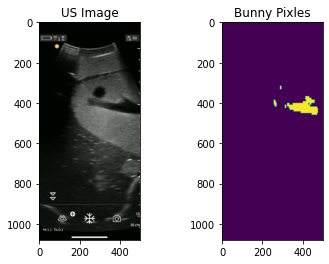

9505 21.58863755917938
Max of max area change percentage in the last 3 iters: 21.58863755917938


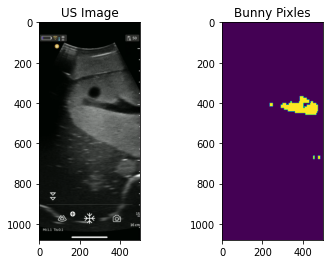

10584 10.194633408919124
Max of max area change percentage in the last 3 iters: 21.58863755917938


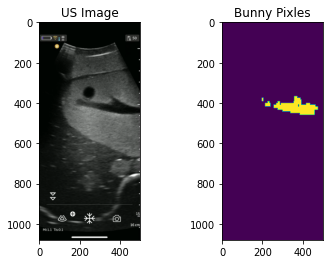

8897 18.96144767899292
Max of max area change percentage in the last 3 iters: 21.58863755917938


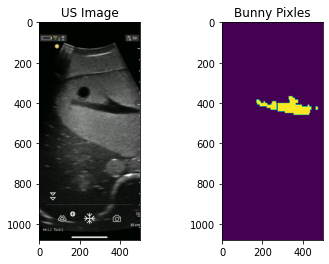

11211 20.64044242262064
Max of max area change percentage in the last 3 iters: 20.64044242262064


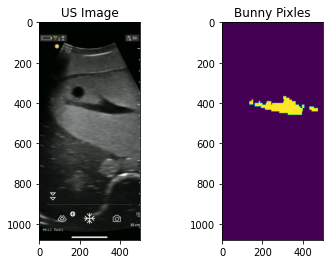

12020 6.73044925124792
Max of max area change percentage in the last 3 iters: 20.64044242262064


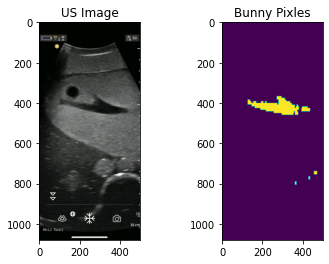

12336 2.5616083009079116
Max of max area change percentage in the last 3 iters: 20.64044242262064


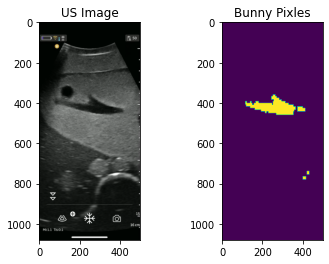

14338 13.962895801366997
Max of max area change percentage in the last 3 iters: 13.962895801366997


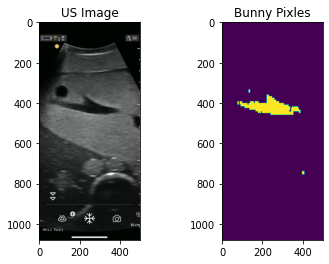

14724 2.621570225482206
Max of max area change percentage in the last 3 iters: 13.962895801366997


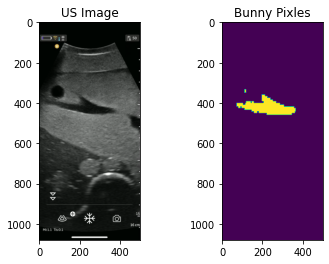

14230 3.471539002108222
Max of max area change percentage in the last 3 iters: 13.962895801366997


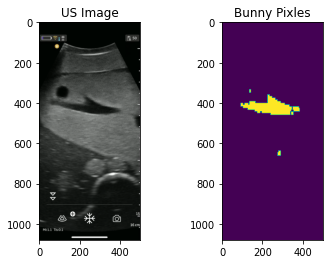

12736 11.730527638190955
Max of max area change percentage in the last 3 iters: 11.730527638190955


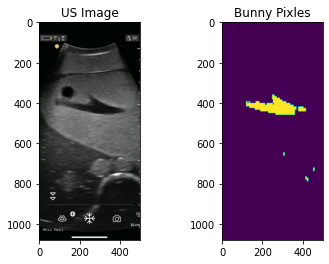

11798 7.950500084760129
Max of max area change percentage in the last 3 iters: 11.730527638190955


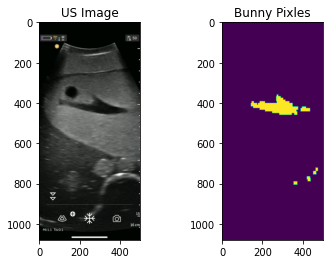

11994 1.6341504085376022
Max of max area change percentage in the last 3 iters: 11.730527638190955


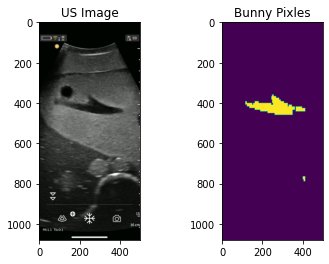

13627 11.98356204593821
Max of max area change percentage in the last 3 iters: 11.98356204593821


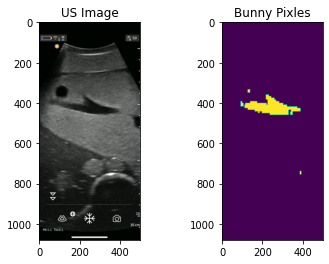

15414 11.593356688724537
Max of max area change percentage in the last 3 iters: 11.98356204593821


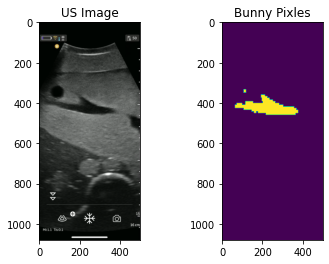

14246 8.198792643549066
Max of max area change percentage in the last 3 iters: 11.98356204593821


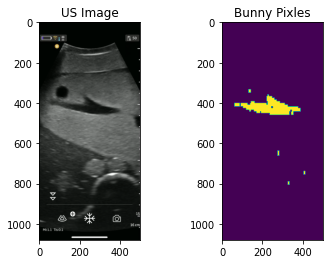

12304 15.783485045513654
Max of max area change percentage in the last 3 iters: 15.783485045513654


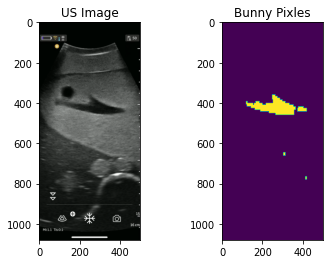

11413 7.806886883378604
Max of max area change percentage in the last 3 iters: 15.783485045513654


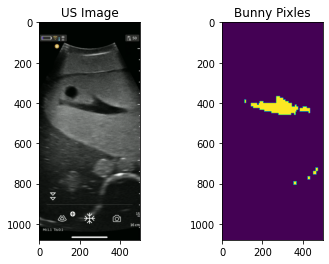

13137 13.123239704650985
Max of max area change percentage in the last 3 iters: 15.783485045513654


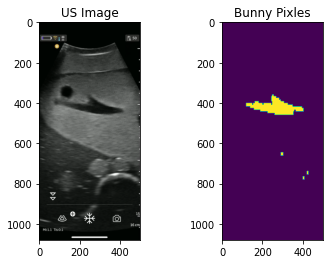

14186 7.394614408571831
Max of max area change percentage in the last 3 iters: 13.123239704650985


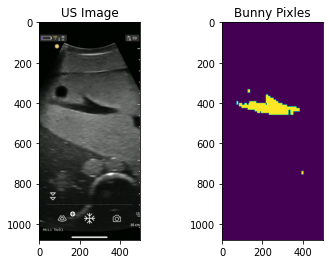

14707 3.542530767661658
Max of max area change percentage in the last 3 iters: 13.123239704650985


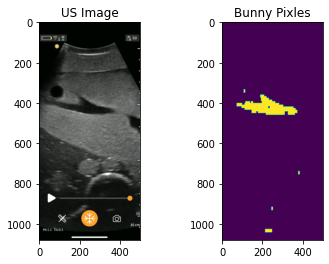

14707 0.0
Max of max area change percentage in the last 3 iters: 7.394614408571831
Mask alignment finished


In [11]:
horizontal_align(ultrasoud_vid,model,rtde_r,rtde_c,device)

In [10]:
from collections import deque
def horizontal_align(ultrasoud_vid,model,rtde_r,rtde_c,device):
    CHANGE_THRESHOLD = 10
    CHANGE_LOOKBACK = 3

    ret, frame = ultrasoud_vid.read()		
    mask = bunny_mask_predict(model,frame,device)
    prev_max_area = max_connected_area(mask)

    area_change_log = deque(maxlen=CHANGE_LOOKBACK)

    while True:
        
        horizontal_align_step(mask, rtde_r, rtde_c)
        
        ret, frame = ultrasoud_vid.read()		
        mask = bunny_mask_predict(model,frame,device)
        max_area = max_connected_area(mask)
        if max_area>0:
            change = np.abs(prev_max_area-max_area)/max_area * 100
            print(max_area,change)
            prev_max_area = max_area
            area_change_log.append(change)
            max_change_past = np.max(area_change_log)
            print('Max of max area change percentage in the last {} iters: {}'.format(CHANGE_LOOKBACK,max_change_past))
            if len(area_change_log)>=CHANGE_LOOKBACK and max_change_past<CHANGE_THRESHOLD:
                print('Mask alignment finished')
                break
        else:
            area_change_log.clear()


        plt.subplot(1,2,1)
        plt.title('US Image')
        plt.imshow(frame)

        plt.subplot(1,2,2)
        plt.title('Bunny Pixles')
        plt.imshow(mask)
        plt.show()


# Move robot to default pose if needed

In [10]:
move_default_pose(rtde_c)

# Clean up

In [79]:
ultrasoud_vid.release()

# Useful Scripts

In [ ]:
# Script for saving default pose
with open('../config/default_pose.yaml','w') as f:
    yaml.safe_dump({'default_pose':rtde_r.getActualTCPPose()},f)